/Users/lamnguyen/Downloads/StarterCode_05 2/Code/gsolve.py:58: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  output = np.linalg.lstsq(A, b)


' Task 3 '

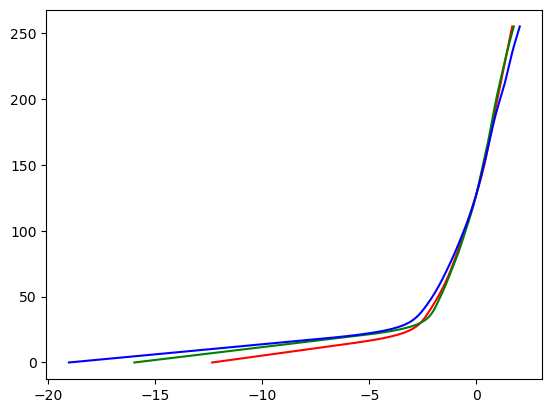

In [3]:
import random
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.pylab import cm


# Based on code by James Tompkin
#
# reads in a directory and parses out the exposure values
# files should be named like: "xxx_yyy.jpg" where
# xxx / yyy is the exposure in seconds.
from gsolve import gsolve


def ParseFiles(calibSetName, dir):
    imageNames = os.listdir(os.path.join(dir, calibSetName))
    
    filePaths = []
    exposures = []
    
    for imageName in imageNames:
        exposure = imageName.split('.')[0].split('_')
        exposures.append(int(exposure[0]) / int(exposure[1]))
        filePaths.append(os.path.join(dir, calibSetName, imageName))
    
    # sort by exposure
    sortedIndices = np.argsort(exposures)[::-1]
    filePaths = [filePaths[i] for i in sortedIndices]
    exposures = [exposures[i] for i in sortedIndices]
    
    return filePaths, exposures


# Setting up the input output paths and the parameters
inputDir = '../Images/'
outputDir = '../Results/'

calibSetName = 'Chapel'

# Parsing the input images to get the file names and corresponding exposure
# values
filePaths, exposures = ParseFiles(calibSetName, inputDir)

""" Task 1 """


def TriangleFunction(z):
    zMin = 0
    zMax = 255
    if z <= (zMin + zMax) / 2:
        return z - zMin
    return zMax - z


def GetZ(images, num_samples):
    rows, cols = images[0].shape[:2]
    sample_rows = np.random.choice(rows, num_samples)
    sample_cols = np.random.choice(cols, num_samples)
    Z = np.zeros((num_samples, len(images)))

    for i in range(num_samples):
        for j in range(len(images)):
            Z[i, j] = images[j][sample_rows[i], sample_cols[i]]
    return Z


def GetWeights():
    w = np.zeros(256)
    for i in range(256):
        if i <= 127:
            w[i] = i
        else:
            w[i] = 255 - i
    return w


def FindCRF(filePaths, exposures):
    rimg = []
    gimg = []
    bimg = []

    for i in range(len(filePaths)):
        b,g,r = cv2.split( cv2.imread(filePaths[i]) )
        rimg.append(r)
        gimg.append(g)
        bimg.append(b)

    imageChnl = [rimg, gimg, bimg]
    crf = np.zeros((256, 3))

    for c in range(3):
        img_chn = imageChnl[c]
        N = 10 * 256 // (len(img_chn) - 1)
        Z = GetZ(img_chn, N)
        w = GetWeights()

        _lambda = 100
        B = np.log(exposures)
        g, _ = gsolve(Z, B, _lambda, w)
        crf[:, c] = g

    return crf, imageChnl


def ComputeRadiance(images, exposure, crf):
    n, h, width, c = images.shape
    radiance = np.zeros(images.shape[1:], dtype=np.float64)

    for c in range(c):
        for i in range(h):
            for j in range(width):
                g = np.array([ crf[int(images[k][i, j][c]) ] for k in range(n)])
                w = np.array([ TriangleFunction(images[k][i, j][c] ) for k in range(n)])

                numin = np.sum(w)
                if numin > 0:
                    radiance[i, j][c] = np.sum(w * (g[:,c] - np.log(exposure)) / numin)
                else:
                    radiance[i, j][c] = 0

    return radiance


def ShowImage(img, title):
    cv2.imshow(title, img)

    # Wait for key press and then close window
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def global_tone_mapping(E, g):
    return (E / np.max(E)) ** g

crf, imageChnl = FindCRF(filePaths, exposures)
plt.plot(crf[:,0], range(256), color='red')
plt.plot(crf[:,1], range(256), color='green')
plt.plot(crf[:,2], range(256), color='blue')
#plt.show()

""" Task 2 """

# Reconstruct the radiance using the calculated CRF
images = []
for f in filePaths:
    images.append(cv2.imread(f))

images = np.array(images)
radiance = ComputeRadiance(images, exposures, crf)

""" Task 3 """

# Perform both local and global tone-mapping



In [1]:
hdr_img = cv2.normalize(radiance, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

def local_tone_mapping(E):
    #Apply a very small number to zero values based on the smallest non-zero value
    E[E == 0] = np.min(E[E != 0]) * 0.0001

    #Compute the intensity (I) by averaging the color channels.
    I = np.mean(E, axis=2)

    #Compute the chrominance channels: (R/I, G/I, B/I)
    RI = E[...,0] / I
    GI = E[...,1] / I
    BI = E[...,2] / I

    #Compute the log intensity: L = log2(I)
    L = np.log2(I)

    #Filter that with a Gaussian filter: B = filter(L). Larger standard deviations result in tonemapped images with more details. Standard deviation of 0.5 to 2 seem reasonable.
    B = gaussian_filter(L, sigma=0.5)

    #Compute the detail layer: D = L − B
    D = L - B

    #Apply an offset and a scale to the base: B0 = (B − o) * s
    o = np.max(B)
    s = 4.5 / (np.max(B) - np.min(B))
    Bp = (B - o) * s

    #Reconstruct the log intensity
    O = 2 ** (Bp + D)

    #Put back the colors: R0, G0, B0 = O * (R/I, G/I, B/I)
    R0 = O * RI
    G0 = O * GI
    B0 = O * BI

    #Apply gamma compression. Without gamma compression the result will look too dark. Values around 0.5 should look fine
    R_gamma = np.power(R0, 0.8)
    G_gamma = np.power(G0, 0.8)
    B_gamma = np.power(B0, 0.8)

    return np.stack([R_gamma, G_gamma, B_gamma], axis=-1)


NameError: name 'cv2' is not defined

In [8]:
ltm = local_tone_mapping(hdr_img)
output = cv2.normalize(ltm, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
ShowImage(output, "Local tone-mapping")